# Anchor A — SDG 12.3 (FWI/FLI) Ingest & Figures
Adds UNEP Food Waste Index (kg/capita) + FAO Food Loss (12.3.1a) and computes
national waste tonnage (FWI × population). Outputs two bar charts + summary tables.


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Project paths (works whether you run from notebooks/ or project root)
root = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
data_ext = root / "data" / "external"
data_sam = root / "data" / "sample"
figs = root / "assets"
data_sam.mkdir(parents=True, exist_ok=True)
figs.mkdir(parents=True, exist_ok=True)

COUNTRIES = {"TZA":"Tanzania", "KEN":"Kenya", "UGA":"Uganda", "RWA":"Rwanda"}
ISO_LIST = list(COUNTRIES.keys())

print("Root:", root)
print("External data:", data_ext)
print("Sample data:", data_sam)
print("Figures:", figs)


Root: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio
External data: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\external
Sample data: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\sample
Figures: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\assets


In [3]:
def find_or_none(pattern: str):
    matches = sorted(data_ext.glob(pattern))
    return matches[-1] if matches else None

def load_fwi_household(path: Path) -> pd.DataFrame:
    """
    Load household FWI (kg/capita/year) CSV.
    Accepts both the curated 'unep_fwi_household_ea.csv' and a country table with kg/capita columns.
    Returns columns: Country Name | Country Code | Year | kg_per_capita | sector | source | study_area
    """
    df = pd.read_csv(path)
    # normalize column names
    lower = {c: c.lower().strip() for c in df.columns}
    df.rename(columns=lower, inplace=True)

    # try to detect key columns
    ctry = next((c for c in df.columns if c in ["country","area","country name"]), None)
    code = next((c for c in df.columns if c in ["iso3","country code","iso_3"]), None)
    year = next((c for c in df.columns if c in ["year","reference year"]), None)
    kgcol = next((c for c in df.columns if "kg" in c and "capita" in c), None)
    sector = "sector" if "sector" in df.columns else None
    source = "source" if "source" in df.columns else None
    study = "study_area" if "study_area" in df.columns else None

    if not kgcol or not ctry:
        raise ValueError("FWI file is missing expected columns (country, kg per capita).")

    # standardize names
    out = df.copy()
    if code and code != "Country Code":
        out.rename(columns={code:"Country Code"}, inplace=True)
    if ctry and ctry != "Country Name":
        out.rename(columns={ctry:"Country Name"}, inplace=True)
    if year and year != "Year":
        out.rename(columns={year:"Year"}, inplace=True)
    if kgcol != "kg_per_capita":
        out.rename(columns={kgcol:"kg_per_capita"}, inplace=True)

    # filter to our countries
    if "Country Code" in out.columns:
        out = out[out["Country Code"].isin(ISO_LIST)].copy()
    else:
        out = out[out["Country Name"].isin(COUNTRIES.values())].copy()

    # coerce types
    out["kg_per_capita"] = pd.to_numeric(out["kg_per_capita"], errors="coerce")
    if "Year" in out.columns:
        out["Year"] = pd.to_numeric(out["Year"], errors="coerce")

    # ensure columns exist
    for col, default in [("Country Code", np.nan), ("Year", np.nan), ("sector", "household"), ("source", np.nan), ("study_area", np.nan)]:
        if col not in out.columns:
            out[col] = default

    # reorder
    return out[["Country Name","Country Code","Year","kg_per_capita","sector","source","study_area"]].dropna(subset=["kg_per_capita"])

def load_pop_wdi_main(path: Path) -> pd.DataFrame:
    """
    Load WDI population API main CSV into tidy form.
    Returns: Country Name | Country Code | Year | population
    """
    try:
        df = pd.read_csv(path, skiprows=4)
    except Exception:
        df = pd.read_csv(path)
    df = df.dropna(axis=1, how='all')
    year_cols = [c for c in df.columns if str(c).isdigit()]
    keep = ["Country Name","Country Code","Indicator Name","Indicator Code"] + year_cols
    keep = [c for c in keep if c in df.columns]
    df = df[keep]
    long = df.melt(id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
                   value_vars=year_cols, var_name="Year", value_name="population")
    long["Year"] = pd.to_numeric(long["Year"], errors="coerce")
    long["population"] = pd.to_numeric(long["population"], errors="coerce")
    long = long.dropna(subset=["Year","population"])
    long = long[long["Country Code"].isin(ISO_LIST)].copy()
    return long[["Country Name","Country Code","Year","population"]].sort_values(["Country Name","Year"])

def load_fli_generic(path: Path) -> pd.DataFrame:
    """
    Load FAO Food Loss (12.3.1a). Accepts a table with Area/Country, Year, Value (+ optional unit).
    Returns: Country Name | Country Code | Year | fli_value | unit
    """
    df = pd.read_csv(path)
    lower = {c: c.lower().strip() for c in df.columns}
    df.rename(columns=lower, inplace=True)
    ctry = next((c for c in df.columns if c in ["area","country","country name"]), None)
    code = next((c for c in df.columns if c in ["area code","country code","iso3"]), None)
    year = next((c for c in df.columns if c == "year"), None)
    value = next((c for c in df.columns if c in ["value","obs_value","value (percent)","fli_value"]), None)
    unit = next((c for c in df.columns if c in ["unit","unit name","unit_measure"]), None)

    if not (ctry and year and value):
        raise ValueError("FLI file needs at least Country/Area, Year, Value columns.")

    out = df.copy()
    ren = {}
    if ctry != "Country Name": ren[ctry] = "Country Name"
    if code and code != "Country Code": ren[code] = "Country Code"
    if year != "Year": ren[year] = "Year"
    if value != "fli_value": ren[value] = "fli_value"
    out.rename(columns=ren, inplace=True)
    if unit and "unit" not in out.columns:
        out["unit"] = df[unit]
    if "unit" not in out.columns:
        out["unit"] = "percent_or_index"

    out["Year"] = pd.to_numeric(out["Year"], errors="coerce")
    out["fli_value"] = pd.to_numeric(out["fli_value"], errors="coerce")
    out = out.dropna(subset=["Year","fli_value"])
    if "Country Code" in out.columns:
        out = out[out["Country Code"].isin(ISO_LIST)].copy()
    else:
        out = out[out["Country Name"].isin(COUNTRIES.values())].copy()
    return out[["Country Name","Country Code","Year","fli_value","unit"]].sort_values(["Country Name","Year"])


In [4]:
# Try exact names first, then fall back to patterns
fwi_path = find_or_none("unep_fwi_kgcap_tza-ken-uga-rwa_*.csv") \
       or find_or_none("unep_fwi_household_ea.csv")

# Accept either 'wdi_' or a typo like 'wid_' in the pop filename
pop_path = find_or_none("wdi_sp.pop.totl_tza-ken-uga-rwa_*.csv") \
       or find_or_none("*sp.pop.totl_tza-ken-uga-rwa_*.csv")

# Your FAOSTAT export name
fli_path = find_or_none("faostat_fli_total_tza-ken-uga-rwa_*.csv")

print("FWI file:", fwi_path.name if fwi_path else None)
print("POP file:", pop_path.name if pop_path else None)
print("FLI file:", fli_path.name if fli_path else None)

if not fwi_path:
    raise FileNotFoundError("Place your UNEP FWI CSV in data/external/ (e.g., unep_fwi_household_ea.csv).")

fwi = load_fwi_household(fwi_path)
pop = load_pop_wdi_main(pop_path) if pop_path else None

# FLI is optional; try to load and continue if it fails
fli = None
if fli_path:
    try:
        fli = load_fli_generic(fli_path)
    except Exception as e:
        print("FLI load failed:", e)
        print("Continuing with FWI only.")


FWI file: unep_fwi_household_ea.csv
POP file: wdi_sp.pop.totl_tza-ken-uga-rwa_20250923.csv
FLI file: faostat_fli_total_tza-ken-uga-rwa_20250923.csv
FLI load failed: FLI file needs at least Country/Area, Year, Value columns.
Continuing with FWI only.


In [5]:
# Latest datapoint per country (drop rows without year for that purpose)
fwi_with_year = fwi.dropna(subset=["Year"]).copy()
fwi_latest = (fwi_with_year.sort_values(["Country Name","Year"])
                          .groupby("Country Name", as_index=False).tail(1))

# Conservative summary: median of last N datapoints (if you want to dampen outliers)
N = 3
fwi_cons = (fwi_with_year.sort_values(["Country Name","Year"])
                         .groupby("Country Name", as_index=False)
                         .apply(lambda g: pd.Series({
                             "Year_start": g["Year"].dropna().tail(N).min(),
                             "Year_end": g["Year"].dropna().tail(N).max(),
                             "kg_per_capita_median": g["kg_per_capita"].dropna().tail(N).median()
                         }))
                        .rename(columns={"Country Name":"Country Name"}))

print("Latest household FWI (kg/capita):")
display(fwi_latest[["Country Name","Year","kg_per_capita","study_area"]].sort_values("Country Name"))

print("Conservative summary (median of last N datapoints per country):")
display(fwi_cons.sort_values("Country Name"))


Latest household FWI (kg/capita):


C:\Users\Admin\AppData\Local\Temp\ipykernel_10112\467137947.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Country Name,Year,kg_per_capita,study_area
6,Kenya,2023.0,40,Homa Bay
14,Rwanda,2023.0,117,Musanze
11,Uganda,2021.0,89,Kampala
3,United Republic of Tanzania,2023.0,245,Iramba District


Conservative summary (median of last N datapoints per country):


,Country Name,Year_start,Year_end,kg_per_capita_median
0,Kenya,2020.0,2023.0,55.0
1,Rwanda,2013.0,2023.0,140.5
2,Uganda,2021.0,2021.0,89.0
3,United Republic of Tanzania,2021.0,2023.0,128.0


In [7]:
if pop is None:
    print("Population CSV not found — skipping tonnes computation. Add 'wdi_sp.pop.totl_tza-ken-uga-rwa_*.csv' to enable.")
    fwi_display = fwi_latest.copy()
    fwi_tonnes = None
else:
    pop_latest = (pop.sort_values(["Country Name","Year"])
                     .groupby("Country Name", as_index=False).tail(1))
    fwi_merge = fwi_latest.merge(pop_latest[["Country Code","population"]], on="Country Code", how="left")
    fwi_merge["tonnes_est"] = (fwi_merge["kg_per_capita"] * fwi_merge["population"]) / 1000.0
    fwi_display = fwi_merge.copy()
    fwi_tonnes = fwi_merge[["Country Name","Year","tonnes_est"]].sort_values("Country Name")

display(fwi_display.sort_values("Country Name"))
if fwi_tonnes is not None:
    display(fwi_tonnes)


,Country Name,Country Code,Year,kg_per_capita,sector,source,study_area,population,tonnes_est
0,Kenya,KEN,2023.0,40,household,UN-Habitat (2023b),Homa Bay,56432944.0,2.257318e+06
1,Rwanda,RWA,2023.0,117,household,UN-Habitat (2023c),Musanze,14256567.0,1.668018e+06
2,Uganda,UGA,2021.0,89,household,UNEP & Uganda Cleaner Production Centre (2021),Kampala,50015092.0,4.451343e+06
3,United Republic of Tanzania,TZA,2023.0,245,household,UN-Habitat (2023a),Iramba District,68560157.0,1.679724e+07


,Country Name,Year,tonnes_est
0,Kenya,2023.0,2.257318e+06
1,Rwanda,2023.0,1.668018e+06
2,Uganda,2021.0,4.451343e+06
3,United Republic of Tanzania,2023.0,1.679724e+07


In [8]:
if fli is not None:
    fli_latest = (fli.sort_values(["Country Name","Year"])
                    .groupby("Country Name", as_index=False).tail(1))
    print("Latest Food Loss (12.3.1a):")
    display(fli_latest[["Country Name","Year","fli_value","unit"]].sort_values("Country Name"))
else:
    print("FLI file not found — skipping FLI charts/tables for now.")


FLI file not found — skipping FLI charts/tables for now.


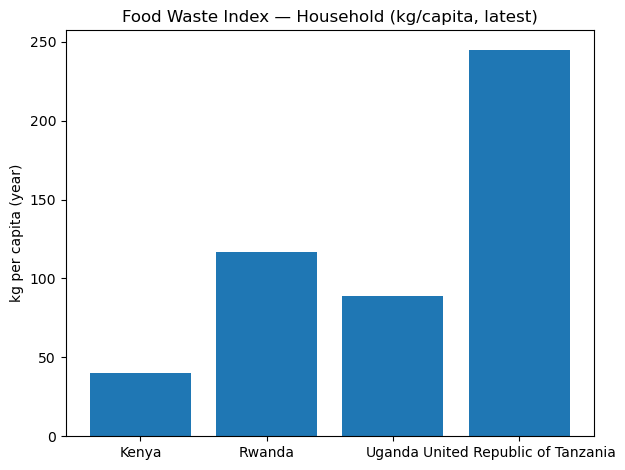

Saved: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\assets\anchor_a_fwi_bar.png


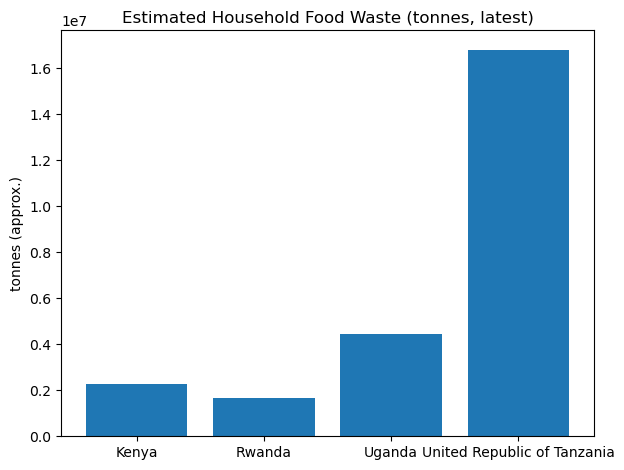

Saved: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\assets\anchor_a_fwi_tonnes_bar.png


In [8]:
# Bar: FWI kg/capita (latest)
plt.figure()
order = sorted(fwi_display["Country Name"].unique())
vals = [float(fwi_display.loc[fwi_display["Country Name"]==c, "kg_per_capita"].values[0]) for c in order]
plt.bar(order, vals)
plt.title("Food Waste Index — Household (kg/capita, latest)")
plt.ylabel("kg per capita (year)")
plt.tight_layout()
f1 = figs / "anchor_a_fwi_bar.png"
plt.savefig(f1, dpi=200)
plt.show()
print("Saved:", f1)

# Bar: Estimated national tonnes (if population provided)
if fwi_tonnes is not None:
    plt.figure()
    tvals = [float(fwi_display.loc[fwi_display["Country Name"]==c, "tonnes_est"].values[0]) for c in order]
    plt.bar(order, tvals)
    plt.title("Estimated Household Food Waste (tonnes, latest)")
    plt.ylabel("tonnes (approx.)")
    plt.tight_layout()
    f2 = figs / "anchor_a_fwi_tonnes_bar.png"
    plt.savefig(f2, dpi=200)
    plt.show()
    print("Saved:", f2)

# Bar: FLI (if available)
if fli is not None:
    plt.figure()
    fli_order = sorted(fli_latest["Country Name"].unique())
    fli_vals = [float(fli_latest.loc[fli_latest["Country Name"]==c, "fli_value"].values[0]) for c in fli_order]
    unit = fli_latest["unit"].iloc[0] if "unit" in fli_latest.columns else ""
    plt.bar(fli_order, fli_vals)
    plt.title(f"Food Loss (latest) [{unit}]")
    plt.ylabel("value")
    plt.tight_layout()
    f3 = figs / "anchor_a_fli_bar.png"
    plt.savefig(f3, dpi=200)
    plt.show()
    print("Saved:", f3)


In [9]:
# Save latest FWI (kg/capita)
fwi_latest_out = data_sam / "unep_fwi_household_latest_kgcap_tza-ken-uga-rwa.csv"
cols = ["Country Name","Year","kg_per_capita","study_area","source"]
fwi_display[cols].sort_values("Country Name").to_csv(fwi_latest_out, index=False)
print("Saved:", fwi_latest_out)

# Save estimated tonnes (if computed)
if fwi_tonnes is not None:
    fwi_tonnes_out = data_sam / "unep_fwi_household_latest_tonnes_tza-ken-uga-rwa.csv"
    fwi_tonnes.to_csv(fwi_tonnes_out, index=False)
    print("Saved:", fwi_tonnes_out)

# Save FLI latest (if available)
if fli is not None:
    fli_latest_out = data_sam / "faostat_fli_latest_tza-ken-uga-rwa.csv"
    fli_latest[["Country Name","Year","fli_value","unit"]].to_csv(fli_latest_out, index=False)
    print("Saved:", fli_latest_out)


Saved: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\sample\unep_fwi_household_latest_kgcap_tza-ken-uga-rwa.csv
Saved: c:\Users\Admin\%USERPROFILE%\Documents\un-portfolio\data\sample\unep_fwi_household_latest_tonnes_tza-ken-uga-rwa.csv


## Notes to paste into your brief
- **FWI (kg/capita, latest):** Replace [X/Y/Z/W] with the values from `fwi_latest` table above.
- **FWI → tonnes:** If population CSV was provided, use the `tonnes_est` values for each country.
- **FLI (latest):** If available, cite each country’s latest value and unit (percent or index).

**Artifacts to list under your brief:**
- `/assets/anchor_a_fwi_bar.png`
- (if population) `/assets/anchor_a_fwi_tonnes_bar.png`
- (if FLI) `/assets/anchor_a_fli_bar.png`
- `/data/sample/unep_fwi_household_latest_kgcap_tza-ken-uga-rwa.csv`
- (if population) `/data/sample/unep_fwi_household_latest_tonnes_tza-ken-uga-rwa.csv`
- (if FLI) `/data/sample/faostat_fli_latest_tza-ken-uga-rwa.csv`
